In [1]:
import torch
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader
from transformers import ViTForImageClassification, ViTFeatureExtractor
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import cv2

d:\Major_WBC_Project\vtproject\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Define image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Vision Transformer Input Size
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

In [3]:
# Load Dataset
train_dataset = datasets.ImageFolder(root=r"D:\Major_WBC_Project\Combined_Dataset\Train", transform=transform)
val_dataset = datasets.ImageFolder(root=r"D:\Major_WBC_Project\Combined_Dataset\Val", transform=transform)

In [4]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

In [5]:
feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224")
model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224", num_labels=len(train_dataset.classes), ignore_mismatched_sizes=True)

d:\Major_WBC_Project\vtproject\lib\site-packages\transformers\models\vit\feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([5]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([5, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using Device: {device}")

Using Device: cuda


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

In [14]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = torch.nn.CrossEntropyLoss()
epochs = 4

In [15]:
# Training Loop
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images).logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        print(f"Epoch [{epoch+1}/{epochs}] Batch [{batch_idx+1}/{len(train_loader)}] Loss: {loss.item():.4f}")

    print(f"Epoch {epoch+1}/{epochs} Completed, Average Loss: {running_loss/len(train_loader):.4f}")


Epoch [1/4] Batch [1/16] Loss: 1.0235
Epoch [1/4] Batch [2/16] Loss: 0.9809
Epoch [1/4] Batch [3/16] Loss: 0.9770
Epoch [1/4] Batch [4/16] Loss: 0.7757
Epoch [1/4] Batch [5/16] Loss: 0.6928
Epoch [1/4] Batch [6/16] Loss: 0.8273
Epoch [1/4] Batch [7/16] Loss: 0.9461
Epoch [1/4] Batch [8/16] Loss: 0.8573
Epoch [1/4] Batch [9/16] Loss: 0.6515
Epoch [1/4] Batch [10/16] Loss: 0.5964
Epoch [1/4] Batch [11/16] Loss: 0.7181
Epoch [1/4] Batch [12/16] Loss: 0.7305
Epoch [1/4] Batch [13/16] Loss: 0.4811
Epoch [1/4] Batch [14/16] Loss: 0.5121
Epoch [1/4] Batch [15/16] Loss: 0.6751
Epoch [1/4] Batch [16/16] Loss: 0.4042
Epoch 1/4 Completed, Average Loss: 0.7406
Epoch [2/4] Batch [1/16] Loss: 0.2416
Epoch [2/4] Batch [2/16] Loss: 0.3319
Epoch [2/4] Batch [3/16] Loss: 0.3351
Epoch [2/4] Batch [4/16] Loss: 0.3833
Epoch [2/4] Batch [5/16] Loss: 0.2378
Epoch [2/4] Batch [6/16] Loss: 0.4332
Epoch [2/4] Batch [7/16] Loss: 0.1688
Epoch [2/4] Batch [8/16] Loss: 0.5191
Epoch [2/4] Batch [9/16] Loss: 0.3231
E

In [16]:
# Save Model
torch.save(model.state_dict(), "Vit_combined_data.pth")
print("Model Saved Successfully ✅")

Model Saved Successfully ✅


In [17]:
model.eval()
y_true, y_pred, y_prob = [], [], []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images).logits
        probs = torch.softmax(outputs, dim=1)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
        y_prob.extend(probs.cpu().numpy())

In [18]:
# Validation Accuracy Calculation
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images).logits
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

val_acc = 100 * correct / total
print(f"Validation Accuracy: {val_acc:.2f}%")

Validation Accuracy: 76.67%


In [19]:
# Classification Report
print("Classification Report:\n", classification_report(y_true, y_pred, target_names=train_dataset.classes))


Classification Report:
               precision    recall  f1-score   support

        Baso       1.00      0.83      0.91        30
      Eosino       0.63      0.73      0.68        30
      Lympho       0.78      0.97      0.87        30
        Mono       0.69      0.73      0.71        30
      Neutro       0.81      0.57      0.67        30

    accuracy                           0.77       150
   macro avg       0.78      0.77      0.77       150
weighted avg       0.78      0.77      0.77       150



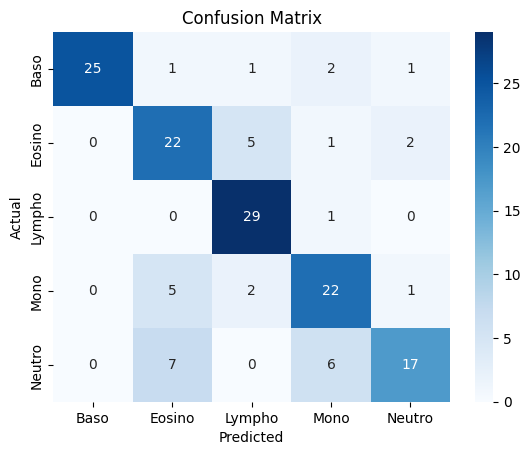

In [20]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

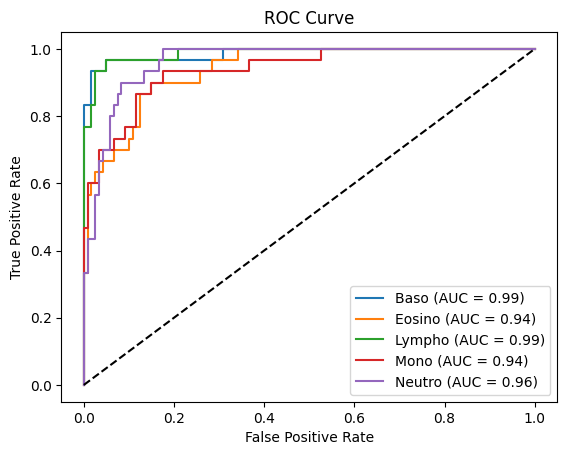

In [21]:
# ROC Curve
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(train_dataset.classes)):
    fpr[i], tpr[i], _ = roc_curve(np.array(y_true) == i, np.array(y_prob)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label=f"{train_dataset.classes[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()


In [22]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, mean_squared_error
# Accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Precision
precision = precision_score(y_true, y_pred, average='weighted')
print(f"Precision: {precision:.4f}")

# Recall
recall = recall_score(y_true, y_pred, average='weighted')
print(f"Recall: {recall:.4f}")

# F1 Score
f1 = f1_score(y_true, y_pred, average='weighted')
print(f"F1 Score: {f1:.4f}")

# RMSE
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print(f"RMSE: {rmse:.4f}")

Accuracy: 0.7667
Precision: 0.7819
Recall: 0.7667
F1 Score: 0.7656
RMSE: 1.0296
